<a href="https://colab.research.google.com/github/furqoncreative/clusterling-bisecting-kmeans/blob/master/Bisecting_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import requests
import pandas as pd

In [10]:
url = 'https://raw.githubusercontent.com/furqoncreative/clusterling-bisecting-kmeans/master/dataset.csv'
df = pd.read_csv(url)
df.head(10)

,28,64,28.1,16,0,0.1,0.2
0,26,0,0,0,0,0,0
1,25,0,0,0,0,0,0
2,25,160,90,37,7,0,0
3,23,16,7,5,1,0,0
4,19,0,0,0,0,0,0
5,32,44,21,11,3,0,0
6,25,41,25,9,0,0,0
7,28,99,52,26,7,0,0
8,25,139,47,57,6,0,0
9,33,194,113,38,13,0,0


In [13]:
data = df.to_numpy()

[[ 26   0   0 ...   0   0   0]
 [ 25   0   0 ...   0   0   0]
 [ 25 160  90 ...   7   0   0]
 ...
 [ 24 105  27 ...   5  78  21]
 [ 18   1   0 ...   0   0   0]
 [ 20   0   0 ...   0   0   0]]


In [19]:
def get_intra(clt, data):
    total_dist = 0
    for i in clt:
        for j in clt:
            dist = (data[i] - data[j]) ** 2
            dist = dist.sum()
            dist = dist ** 0.5
            total_dist = total_dist + dist

    return total_dist / (len(clt) * len(clt))

In [20]:
def get_inter(clt1, clt2, data):
    total_dist = 0
    for i in clt1:
        for j in clt2:
            dist = (data[i] - data[j]) ** 2
            dist = dist.sum()
            dist = dist ** 0.5
            total_dist = total_dist + dist

    return total_dist / (len(clt1) * len(clt2))

In [21]:
def get_center(data_idx, data):
    center = np.zeros(7, dtype='float')
    for i in data_idx:
        center = center + data[i]

    return center / len(data_idx)

In [23]:
def get_SSE(data_idx, data, center):
    part_data = []
    for i in data_idx:
        part_data.append(data[i])
    sse = (center - part_data) ** 2
    sse = sse.sum(axis=1)
    sse = sse.sum(axis=0)
    return sse

In [24]:
def kmeans(k, data_idx, data, cls_res, center_idx, cluster_number):
    center_list = random.sample(data_idx, k)
    cls_center = []
    temp_cls_res = []
    temp_cls_res.extend(cls_res)

    for i in center_list:
        cls_center.append(data[i])

    while True:
        is_changed = 0
        cls_count = np.zeros(k, dtype=float)
        cls_avg = np.zeros([k, 7])
        sse_idx1 = []
        sse_idx2 = []
        for i in data_idx:
            point = data[i]
            dist = (point - cls_center) ** 2
            dist = dist.sum(axis=1)
            dist = dist ** 0.5
            min = dist.argsort()[0]
            cls_avg[min] = cls_avg[min] + data[i]
            if min == 0:
                temp_cls_res[i] = center_idx
            else:
                temp_cls_res[i] = cluster_number

            cls_count[min] = cls_count[min] + 1

        for i in range(0, k):
            avg = cls_avg[i] / cls_count[i]  
            if not (np.array_equal(np.array(cls_center[i]), avg)):
                cls_center[i] = avg
                is_changed = 1

        if is_changed == 0:
            break

    for i in data_idx:
        if temp_cls_res[i] == center_idx:
            sse_idx1.append(i)
        else:
            sse_idx2.append(i)
    sse1 = get_SSE(sse_idx1, data, cls_center[0])
    sse2 = get_SSE(sse_idx2, data, cls_center[1])
    return cls_center, temp_cls_res, [sse1, sse2]

In [25]:
def bisecting(k, data):
    cls_center = []
    cls_SSE = np.zeros(k, dtype='float')
    cls_start = np.zeros(7, dtype='float')
    cls_res = np.zeros(len(data), dtype='int')
    cls_count = np.zeros(k, dtype='int')
    for i in data:
        cls_start = cls_start + i
    cls_start = cls_start / len(data)
    cls_center.append(cls_start)

    while len(cls_center) < k: 
        cls_count = np.zeros(k, dtype=float)
        cls_avg = np.zeros([k, 7])

        if len(cls_center) == 1:
            for i in range(0, len(cls_center)):
                cmp_SSE = []
                data_idx = []
                for j in range(0, len(data)):
                    if cls_res[j] == i:
                        data_idx.append(j)
            center, temp_res, sse_list = kmeans(2, data_idx, data, cls_res, 0, 1)

            cls_center = center
            cls_res = temp_res
            cls_SSE[0] = sse_list[0]
            cls_SSE[1] = sse_list[1]
        else:
            temp_SSE = []
            temp_center = []
            cmp_SSE = []
            res = []
            for i in range(0, len(cls_center)):
                data_idx = []
                for j in range(0, len(data)):
                    if cls_res[j] == i:
                        data_idx.append(j)

                center, temp_res, sse_list = kmeans(2, data_idx, data, cls_res, i, len(cls_center))
                sse_list.append(cls_SSE[i])
                res.append(temp_res)
                temp_center.append(center)
                temp_SSE.append(sse_list)
            for i in temp_SSE:  
                cmp_SSE.append(i[2] - i[0] - i[1])
            min = np.array(cmp_SSE).argsort()[len(cmp_SSE) - 1]
            cls_center[min] = temp_center[0]
            cls_center.append(temp_center[1])
            cls_res = res[min]
            cls_SSE[min] = temp_SSE[min][0]
            cls_SSE[len(cls_center) - 1] = temp_SSE[min][1]
        # print("RES = ", count_result(cls_res))
    for i in range(0, len(data)):
        cls_count[cls_res[i]] = cls_count[cls_res[i]] + 1

    return cls_res

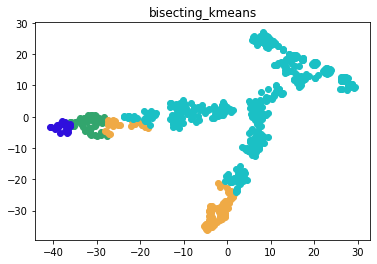

intra =  [118.95772169550075, 120.7868664302284, 45.85514462617204, 229.6716276342873] 128.81784009654712 4304.003443332397 65.60490411038185
inter =  [236.4803723323659, 289.9161803132245, 328.9693952257989, 177.16020402108626, 519.7861558799294, 585.6359756864781] 356.32471390981385 21820.715399184774 147.71836513847822
SSE =  [418752.04081632657, 930767.8125, 666733.5112219452, 946629.5833333334] 740720.7369679013 46913573701.243614 216595.41477428284


In [26]:
k = 4
cls_res = bisecting(k, data)
cls_count = np.zeros(k, dtype='int')
for i in range(0, len(data)):
    cls_count[cls_res[i]] = cls_count[cls_res[i]] + 1

model = TSNE(learning_rate=100)
transformed = model.fit_transform(data)

collection_list = []
intra_class = []
inter_class = []
sse_list = []
for i in range(0, k):  # 可视化计算结果
    result = []
    xs = []
    ys = []
    for j in range(0, len(data)):
        if cls_res[j] == i:
            xs.append(transformed[j][0])
            ys.append(transformed[j][1])
            result.append(j)
    plt.title("bisecting_kmeans")
    plt.scatter(xs, ys, c=[np.random.rand(3, )])

    collection_list.append(result)
plt.show()

for i in range(0, len(collection_list)):
    for j in range(i, len(collection_list)):
        if i == j:
            intra_class.append(get_intra(collection_list[j], data))
            sse_list.append(get_SSE(collection_list[i], data, get_center(collection_list[i], data)))
        else:
            inter_class.append(get_inter(collection_list[i], collection_list[j], data))

print("intra = ", intra_class, np.mean(intra_class), np.var(intra_class), np.std(intra_class))
print("inter = ", inter_class, np.mean(inter_class), np.var(inter_class), np.std(inter_class))
print("SSE = ", sse_list, np.mean(sse_list), np.var(sse_list), np.std(sse_list))